<a href="https://colab.research.google.com/github/tcheskko/TimeSeries_OceanAtmo/blob/main/OceanAtmoTimeSeries_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving OceanoAtmosferaDataSet.csv to OceanoAtmosferaDataSet.csv


#Ajustes no dataset 'OceanoAtmosferaDataSet'

In [4]:
dfOceanAtmo = pd.read_csv("OceanoAtmosferaDataSet.csv")

In [5]:
dfOceanAtmo.head(10)

,DATE,PIR_SSS,PIR_DYN,PIR_PREC,PIR_SST,PIR_WSPD,PIR_WDIR,PIR_WDIRCR,INM_PREC_TOTAL,INM_TEMP_BSE,INM_UMID_AR,INM_VENT_DIR,INM_VENT_VEL,INM_VENT_DROS
0,2018-01-01,37.21,98.63,0.00,26.61,3.40,199.10,WSW,0.00,25.70,73.00,359.00,2.70,SW
1,2018-01-02,37.22,99.70,0.00,26.65,3.40,190.20,S,0.00,26.70,73.00,354.00,1.40,ENE
2,2018-01-03,37.21,100.37,-0.04,26.61,4.20,206.20,WSW,0.00,24.90,66.00,126.00,2.00,ENE
3,2018-01-04,37.20,99.70,-0.02,26.68,3.70,196.20,WSW,0.00,26.80,54.00,294.00,1.70,SSW
4,2018-01-05,37.20,99.59,-0.02,26.74,3.60,229.30,W,0.00,26.60,63.00,337.00,2.90,SW
5,2018-01-06,37.20,99.57,-0.03,26.77,4.00,266.50,WNW,0.00,28.40,57.00,11.00,1.90,SW
6,2018-01-07,37.20,99.78,0.02,26.80,3.20,264.10,WNW,0.00,24.80,61.00,158.00,4.10,WSW
7,2018-01-08,37.20,99.87,0.00,26.80,4.00,276.60,WNW,0.00,23.00,71.00,162.00,1.80,S
8,2018-01-09,37.21,99.74,-0.02,26.83,4.90,295.30,NW,0.00,21.70,90.00,194.00,1.50,S
9,2018-01-10,37.21,99.75,0.17,26.94,3.80,294.50,NW,3.80,22.10,92.00,6.00,0.90,SW


In [6]:
dfOceanAtmo.set_index('DATE', inplace=True)

In [7]:
dfOceanAtmo.index

Index(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
       '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10',
       ...
       '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
       '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'],
      dtype='object', name='DATE', length=1826)

#[PIR_DYN] Dynamic Sea Surface

* Criando datasets de teste e treino
* Treinamento
* Avaliação da precisão com conjunto de testes
* Testes aplicados em período posterior ao treinamento para garantir que o modelo não obtenha informações futuras

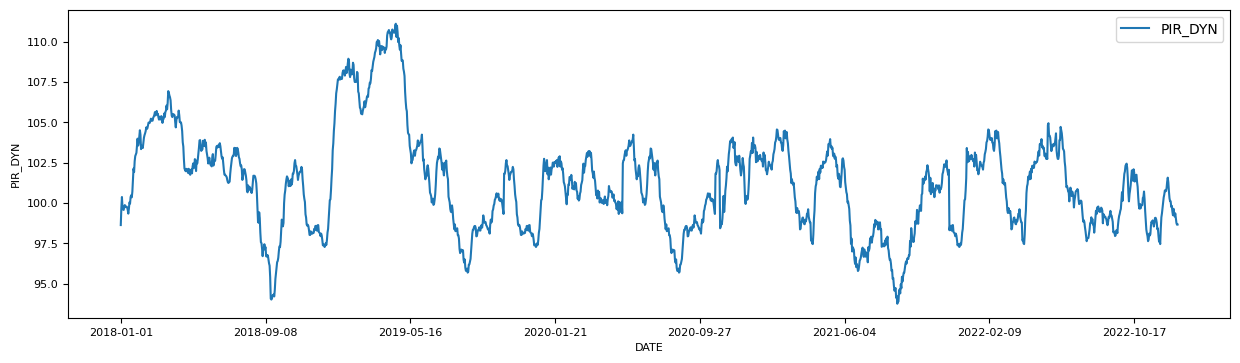

In [8]:
dfOceanAtmo.plot(y='PIR_DYN', subplots=True, figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_DYN', fontsize=8)
plt.show()

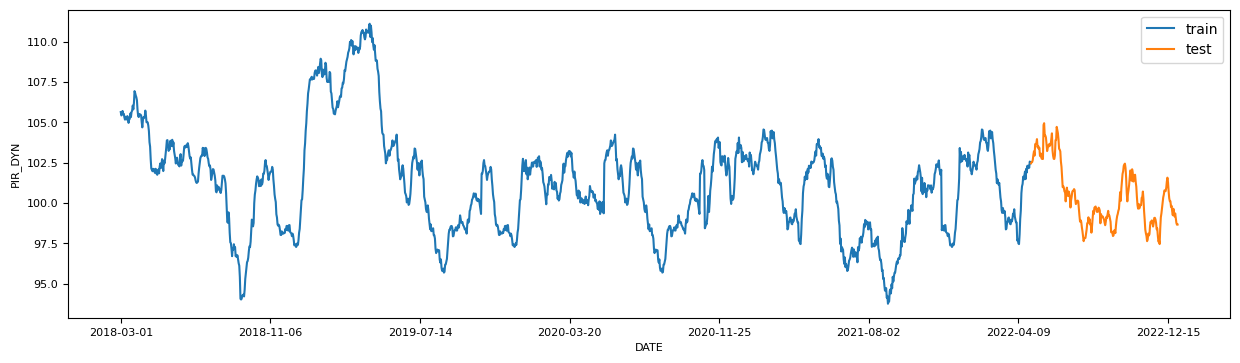

In [9]:


train_start_dt = '2018-03-01'
test_start_dt = '2022-04-30'

dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['PIR_DYN']].rename(columns={'PIR_DYN':'train'}) \
    .join(dfOceanAtmo[test_start_dt:][['PIR_DYN']].rename(columns={'PIR_DYN':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_DYN', fontsize=8)
plt.show()




##Preparação dos dados para treinamento
* Filtragem e dimensionamento;


In [10]:
train = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_DYN']]
test = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['PIR_DYN']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [11]:
scaler = MinMaxScaler()
train['PIR_DYN'] = scaler.fit_transform(train)
train.head(10)

,PIR_DYN
DATE,
2018-03-01,0.68
2018-03-02,0.67
2018-03-03,0.68
2018-03-04,0.69
2018-03-05,0.68
2018-03-06,0.68
2018-03-07,0.67
2018-03-08,0.66
2018-03-09,0.67


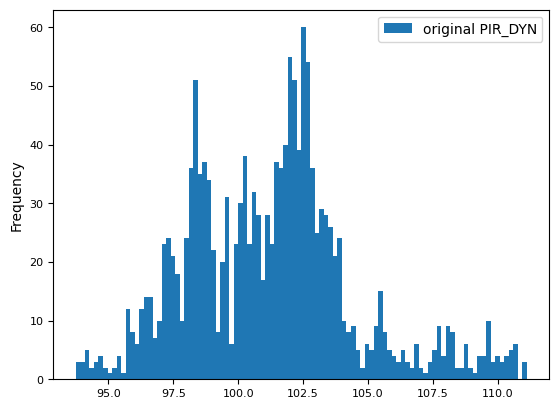

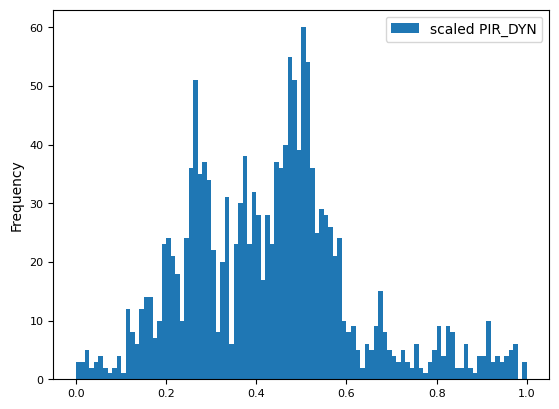

In [12]:
#Dados originais x dados escalados

dfOceanAtmo[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_DYN']].rename(columns={'PIR_DYN':'original PIR_DYN'}).plot.hist(bins=100, fontsize=8)
train.rename(columns={'PIR_DYN':'scaled PIR_DYN'}).plot.hist(bins=100, fontsize=8)
plt.show()

In [13]:
#Após os dados escalados calibrados, escalamos os dados de teste

test['PIR_DYN'] = scaler.transform(test)
test.head()

,PIR_DYN
DATE,
2022-04-30,0.50
2022-05-01,0.51
2022-05-02,0.51
2022-05-03,0.51
2022-05-04,0.53


##Implementação do modelo ARIMA | PIR_DYN
* Definição do modelo utilizando SARIMAX() com os parametros:
  - p: autoregressão (relação entre observaçãoa tual e anteriores);
  - d: integração (diferenciação entre observações)
  - q: média movel (erro do modelo combinado a termos de erros anteriores)

* Execução do auto_arima() para encontrar os melhores valores para os parametros p,d,q
* Preparação do modelo de treinamento chamando a função fit();


In [14]:
#Definição inicial do valor de horizonte de previsão
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'days')

Forecasting horizon: 3 days


In [15]:
#Selecionar os melhores valores para os parâmetros ARIMA é complexo.
#Devido a isso, utilizamos a biblioteca pyramid.autoarima() para encontrar esses dados

!pip install pmdarima
from pmdarima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.0 MB/s eta 0:00:00


In [16]:
stepwise_fit = auto_arima(train, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 7,    #7:daily, 12:monthly
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',         # we don't want to know if an order does not work
                          suppress_warnings = True,       # we don't want convergence warnings
                          stepwise = True)                # set to stepwise

# To print the summary
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=13.17 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-3368.120, Time=0.99 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-6567.557, Time=7.37 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=-4609.772, Time=15.20 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-3369.941, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-6214.754, Time=0.35 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=-6685.500, Time=16.14 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=15.65 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=8.26 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=-3424.475, Time=4.49 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=-6691.026, Time=15.35 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=-6582.061, Time=5.26 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=19.20 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=6.94 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=-

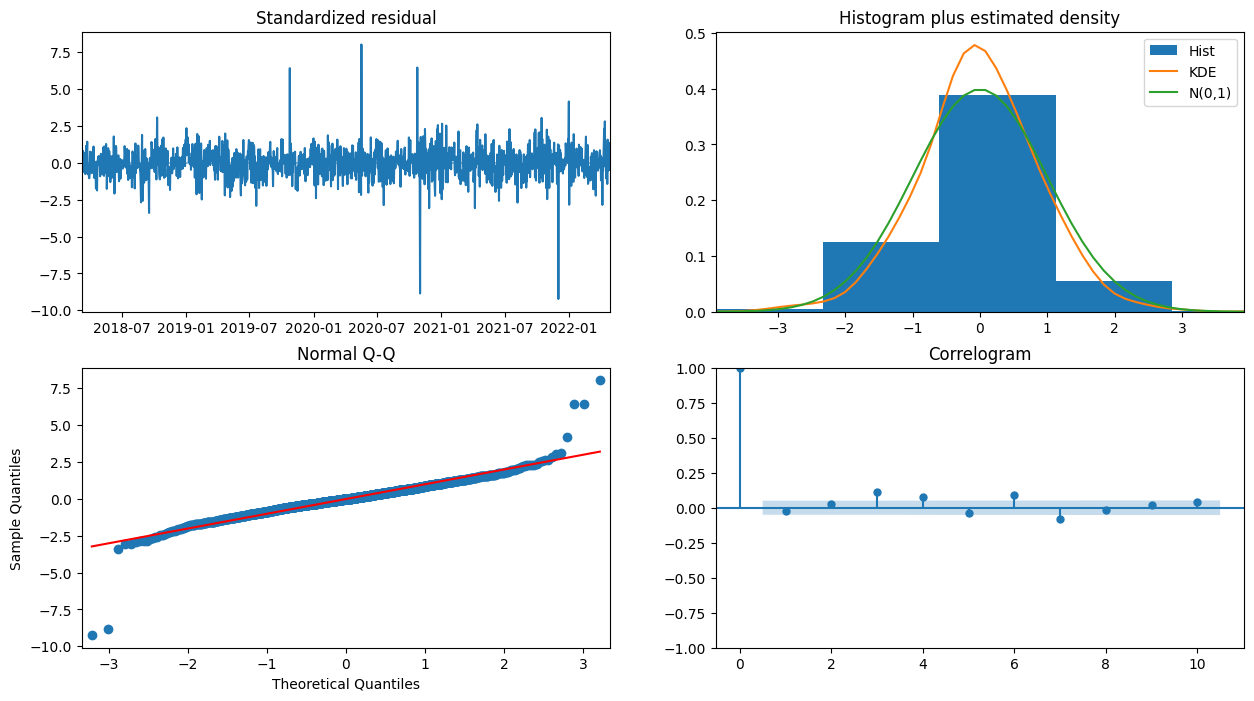

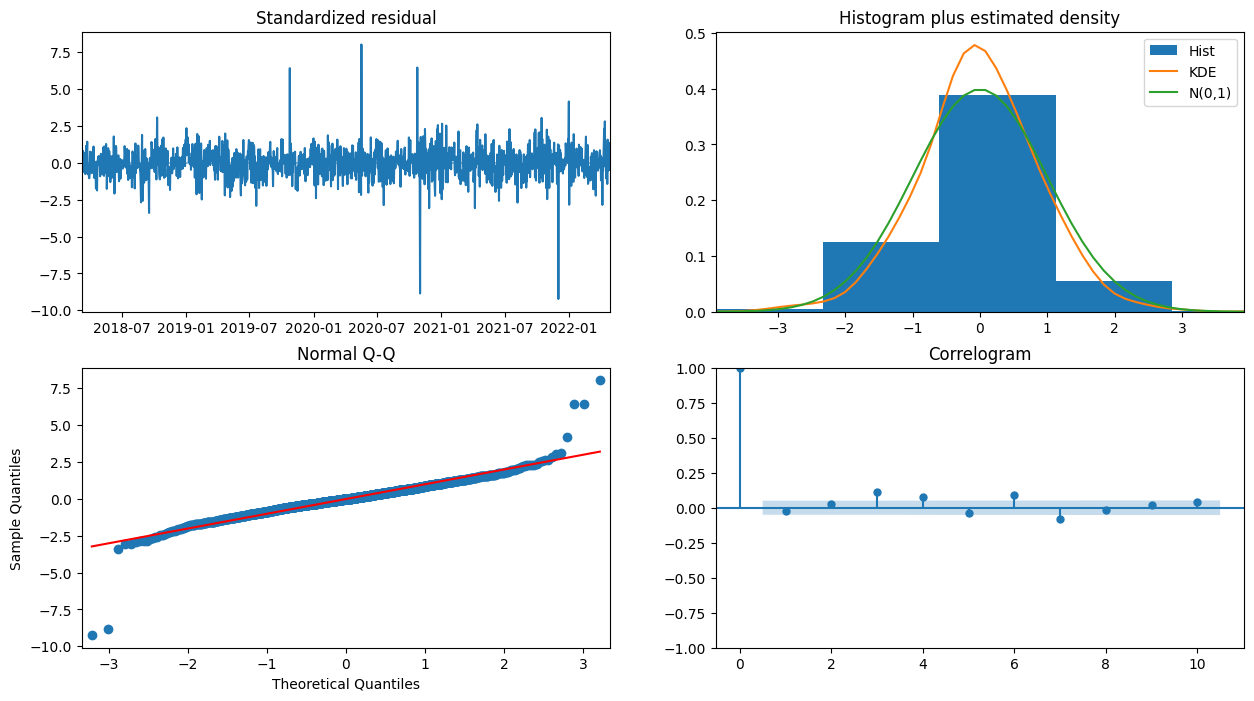

In [17]:
stepwise_fit.plot_diagnostics(figsize=(15,8))

In [18]:
#Encontrado os melhores valores para as variaveis p,d,q - seguimos para construção do modelo
order = (3, 0, 0)
seasonal_order = (2, 1, 1, 7)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                             PIR_DYN   No. Observations:                 1521
Model:             SARIMAX(3, 0, 0)x(2, 1, [1], 7)   Log Likelihood                3551.832
Date:                             Sun, 15 Oct 2023   AIC                          -7089.664
Time:                                     19:30:28   BIC                          -7052.406
Sample:                                 03-01-2018   HQIC                         -7075.791
                                      - 04-29-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0578      0.022     47.483      0.000       1.014       1.101
ar.L2          0.0882      

##Avaliação do modelo

* Validação walk-forward: novos treinamentos a cada vez que os dados estão disponiveis


In [19]:
#Criando um test data point para cada horizonte de previsão:

test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['PIR_DYN+'+str(t)] = test_shifted['PIR_DYN'].shift(-t)

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,PIR_DYN,PIR_DYN+1,PIR_DYN+2
DATE,,,
2022-04-30,0.50,0.51,0.51
2022-05-01,0.51,0.51,0.51
2022-05-02,0.51,0.51,0.53
2022-05-03,0.51,0.53,0.54
2022-05-04,0.53,0.54,0.53


In [20]:
#Fazendo previsões nos dados de teste usando a abordagem de janela deslizante

%%time
training_window = 30 # dedicate 30 days for training

train_ts = train['PIR_DYN']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    #print(test_ts.index[t])
    #print(t+1, ': predicted =', yhat, 'expected =', obs)

CPU times: user 1min 28s, sys: 294 ms, total: 1min 28s
Wall time: 1min 39s


In [21]:
#Comparação entre dados atuais e previstos

eval_df = pd.DataFrame(predictions, columns=['d+'+str(t) for t in range(1, HORIZON+1)])
eval_df['DATE'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='DATE', value_name='prediction', var_name='day')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,DATE,day,prediction,actual
0,2022-04-30,d+1,102.52,102.46
1,2022-05-01,d+1,102.47,102.53
2,2022-05-02,d+1,102.42,102.54
3,2022-05-03,d+1,102.47,102.67
4,2022-05-04,d+1,102.31,102.98


##Validação da acurácia do modelo

* Teste do erro percentual médio absoluto (MAPE - [Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error))


In [22]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [23]:
#Equação:

if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('day')['APE'].mean())

day
d+1   0.00
d+2   0.01
d+3   0.01
Name: APE, dtype: float64


In [24]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['day'] == 'd+1']['prediction'], eval_df[eval_df['day'] == 'd+1']['actual']))*100, '%')
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

One step forecast MAPE:  0.42405089232848164 %
Multi-step forecast MAPE:  0.6163482657588595 %


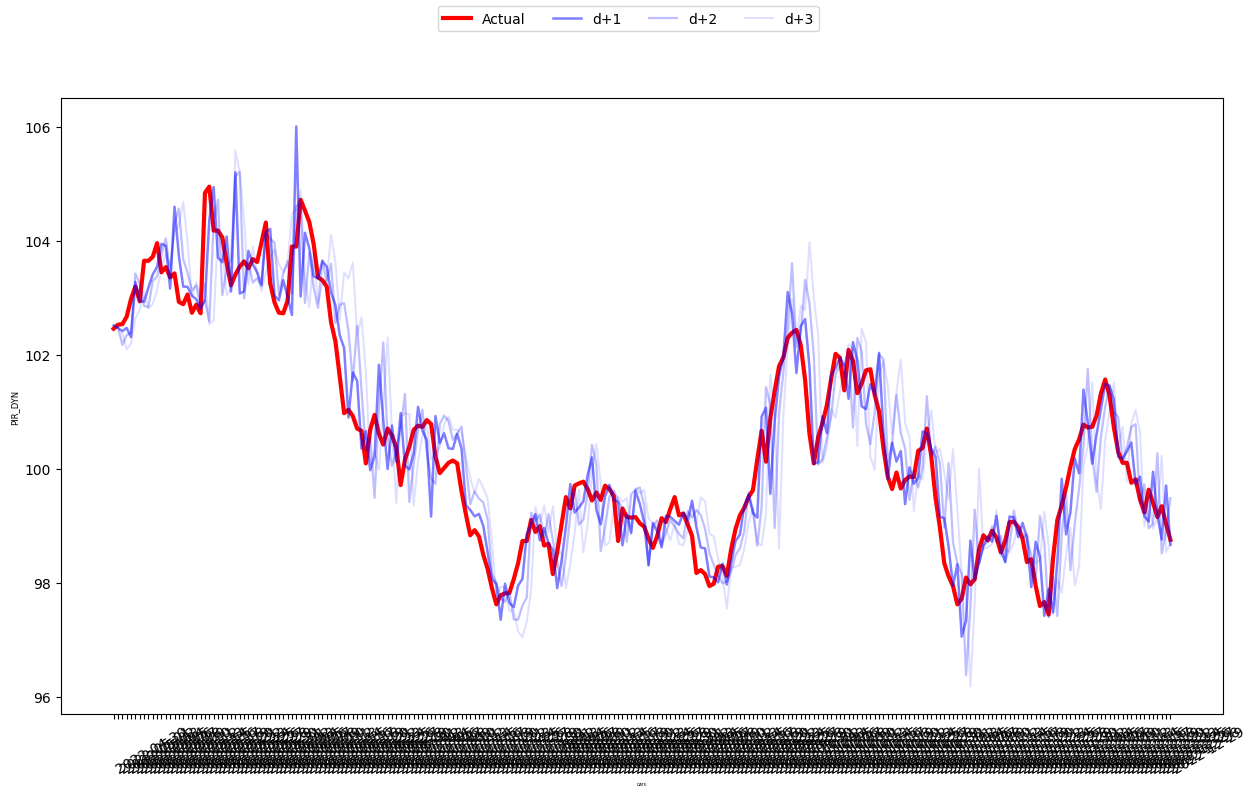

In [25]:
#Visualização da acurácia em gráfico

if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='DATE', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.day=='d+1')][['DATE', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['d+'+str(t)] = eval_df[(eval_df.day=='d+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df['DATE'], plot_df['actual'], color='red', linewidth=3, label="Actual")


    for t in range(1, HORIZON+1):
        x = plot_df['DATE'][(t-1):]
        y = plot_df['d+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=2*math.pow(.9,t), alpha=math.pow(0.5,t), label='d+'+str(t))


    fig.legend(loc='upper center', ncol=4)


plt.xlabel('DATE', fontsize=3,)
plt.xticks(rotation=30, ha='left')
plt.ylabel('PIR_DYN', fontsize=6)
plt.show()

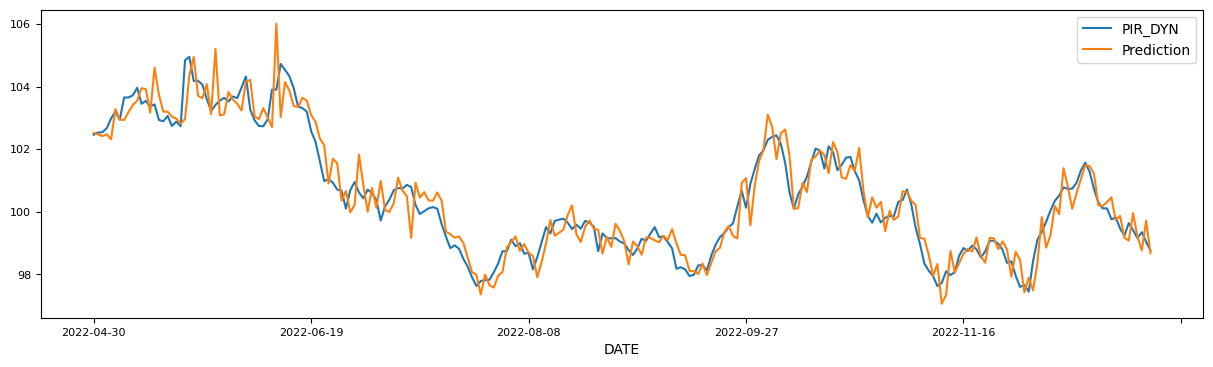

In [26]:
plot_d_1 = eval_df[(eval_df.day=='d+1')][['DATE', 'actual', 'prediction']]
plot_d_1.plot(x='DATE', y=['actual', 'prediction'], figsize=(15, 4), fontsize=8)
plt.legend(["PIR_DYN", "Prediction"]);


<Axes: xlabel='DATE'>

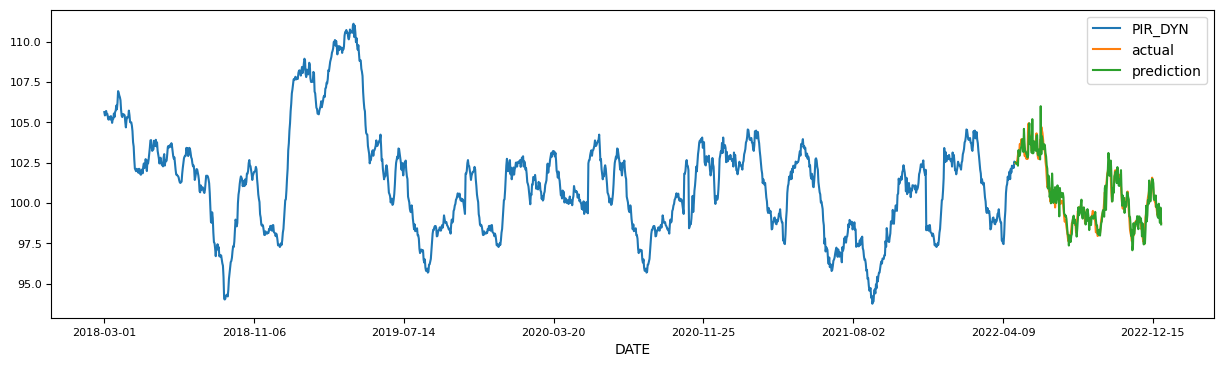

In [27]:
train_c = train.copy()
train_c[['PIR_DYN']] = scaler.inverse_transform(train_c[['PIR_DYN']])

eval_d_1 = eval_df[(eval_df.day=='d+1')][['DATE', 'actual', 'prediction']]
#eval_c.drop(['day'], axis=1, inplace=True)
#eval_c.drop(['APE'], axis=1, inplace=True)

eval_d_1.set_index('DATE', inplace=True)


pd.concat([train_c,eval_d_1],axis=1).plot(figsize=(15, 4), fontsize=8)

#[PIR_SST] Sea Surface Temperature





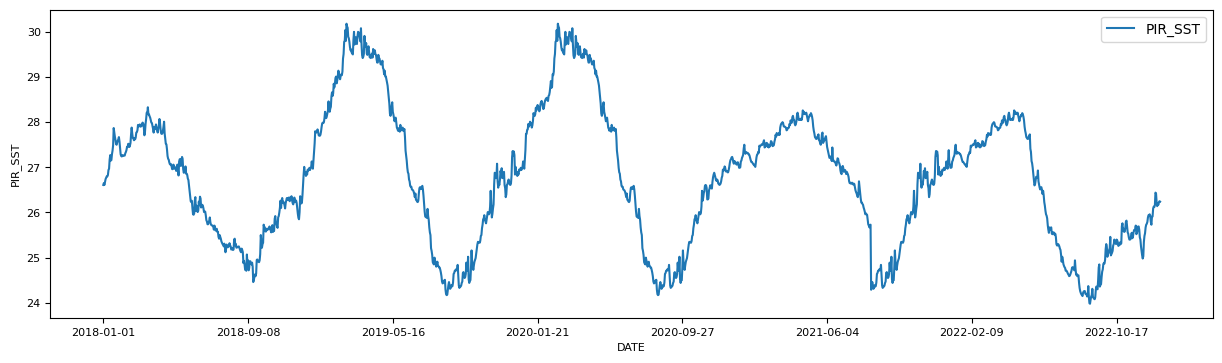

In [28]:
dfOceanAtmo.plot(y='PIR_SST', subplots=True, figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_SST', fontsize=8)
plt.show()

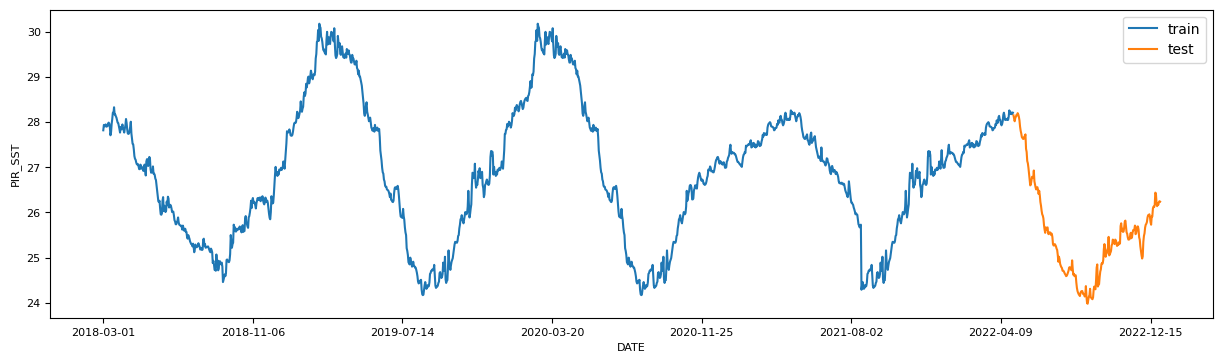

In [29]:

dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['PIR_SST']].rename(columns={'PIR_SST':'train'}) \
    .join(dfOceanAtmo[test_start_dt:][['PIR_SST']].rename(columns={'PIR_SST':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_SST', fontsize=8)
plt.show()

###Preparação dos dados para treinamento | PIR_SST

In [30]:
train_sst = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_SST']]
test_sst = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['PIR_SST']]

print('Training data shape: ', train_sst.shape)
print('Test data shape: ', test_sst.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [31]:
scaler = MinMaxScaler()
train_sst['PIR_SST'] = scaler.fit_transform(train_sst)
train_sst.head(10)

,PIR_SST
DATE,
2018-03-01,0.61
2018-03-02,0.63
2018-03-03,0.62
2018-03-04,0.63
2018-03-05,0.63
2018-03-06,0.62
2018-03-07,0.62
2018-03-08,0.62
2018-03-09,0.63


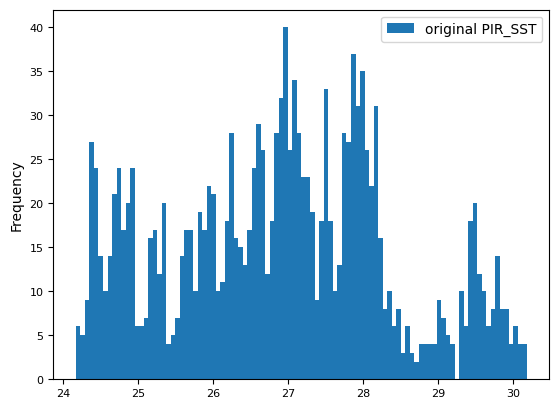

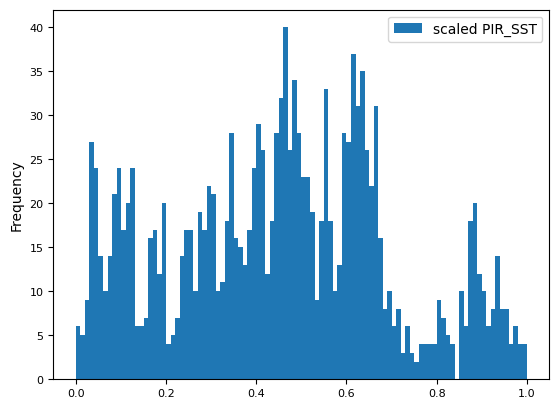

In [32]:
#Dados originais x dados escalados

dfOceanAtmo[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['PIR_SST']].rename(columns={'PIR_SST':'original PIR_SST'}).plot.hist(bins=100, fontsize=8)
train_sst.rename(columns={'PIR_SST':'scaled PIR_SST'}).plot.hist(bins=100, fontsize=8)
plt.show()

In [33]:
#Após os dados escalados calibrados, escalamos os dados de teste

test_sst['PIR_SST'] = scaler.transform(test_sst)
test_sst.head()

,PIR_SST
DATE,
2022-04-30,0.66
2022-05-01,0.65
2022-05-02,0.64
2022-05-03,0.65
2022-05-04,0.66


###Implementação do modelo ARIMA | PIR_SST


In [34]:
stepwise_sst = auto_arima(train_sst, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 7, #7:daily, 12:monthly
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# To print the summary
print(stepwise_sst.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=8.25 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-4545.584, Time=0.26 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-7064.772, Time=7.79 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=-5693.889, Time=3.52 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-4547.557, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-6716.968, Time=1.02 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=-7229.040, Time=11.45 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=-7472.584, Time=13.01 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=8.71 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=-7491.587, Time=15.01 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=16.72 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=-4786.687, Time=14.82 sec
 ARIMA(2,0,0)(2,1,2)[7] intercept   : AIC=-7305.840, Time=20.39 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=-7256.838, Time=18.46 sec
 ARIMA(0,0,1)(2,1,2)[7] interc

In [35]:
#Encontrado os melhores valores para as variaveis p,d,q - seguimos para construção do modelo
order = (1, 0, 0)
seasonal_order = (2, 1, 2, 7)

model_sst = SARIMAX(endog=train_sst, order=order, seasonal_order=seasonal_order)
results_sst = model_sst.fit()

print(results_sst.summary())


                                       SARIMAX Results                                        
Dep. Variable:                                PIR_SST   No. Observations:                 1521
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood                3794.113
Date:                                Sun, 15 Oct 2023   AIC                          -7576.227
Time:                                        19:35:27   BIC                          -7544.292
Sample:                                    03-01-2018   HQIC                         -7564.335
                                         - 04-29-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9975      0.003    331.125      0.000       0.992       1.003
ar.

In [36]:
#Criando um test data point para cada horizonte de previsão:

test_shifted_sst = test_sst.copy()

for t in range(1, HORIZON):
    test_shifted_sst['PIR_SST+'+str(t)] = test_shifted_sst['PIR_SST'].shift(-t)

test_shifted_sst = test_shifted_sst.dropna(how='any')
test_shifted_sst.head(5)

,PIR_SST,PIR_SST+1,PIR_SST+2
DATE,,,
2022-04-30,0.66,0.65,0.64
2022-05-01,0.65,0.64,0.65
2022-05-02,0.64,0.65,0.66
2022-05-03,0.65,0.66,0.66
2022-05-04,0.66,0.66,0.66


In [37]:
#Fazendo previsões nos dados de teste usando a abordagem de janela deslizante

%%time
training_window = 30 # dedicate 30 days for training

train_ts_sst = train_sst['PIR_SST']
test_ts_sst = test_shifted_sst

history_sst = [x for x in train_ts_sst]
history_sst = history_sst[(-training_window):]

predictions_sst = list()

#order = (3, 0, 0)
#seasonal_order = (2, 1, 1, 7)

for t in range(test_ts_sst.shape[0]):
    model_sst = SARIMAX(endog=history_sst, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    model_fit_sst = model_sst.fit()
    yhat_sst = model_fit_sst.forecast(steps = HORIZON)
    predictions_sst.append(yhat_sst)
    obs_sst = list(test_ts_sst.iloc[t])
    # move the training window
    history_sst.append(obs_sst[0])
    history_sst.pop(0)
    #print(test_ts_sst.index[t])
    #print(t+1, ': predicted =', yhat_sst, 'expected =', obs_sst)

CPU times: user 48.4 s, sys: 222 ms, total: 48.6 s
Wall time: 49.9 s


In [38]:
#Comparação entre dados atuais e previstos

eval_df_sst = pd.DataFrame(predictions_sst, columns=['d+'+str(t) for t in range(1, HORIZON+1)])
eval_df_sst['DATE'] = test_sst.index[0:len(test_sst.index)-HORIZON+1]
eval_df_sst = pd.melt(eval_df_sst, id_vars='DATE', value_name='prediction', var_name='day')
eval_df_sst['actual'] = np.array(np.transpose(test_ts_sst)).ravel()
eval_df_sst[['prediction', 'actual']] = scaler.inverse_transform(eval_df_sst[['prediction', 'actual']])
eval_df_sst.head()

,DATE,day,prediction,actual
0,2022-04-30,d+1,28.32,28.15
1,2022-05-01,d+1,28.13,28.08
2,2022-05-02,d+1,28.16,28.02
3,2022-05-03,d+1,28.03,28.09
4,2022-05-04,d+1,28.12,28.12


###Validação da acurácia do modelo | PIR_SST


In [39]:
#Equação:

if(HORIZON > 1):
    eval_df_sst['APE'] = (eval_df_sst['prediction'] - eval_df_sst['actual']).abs() / eval_df_sst['actual']
    print(eval_df_sst.groupby('day')['APE'].mean())

day
d+1   0.00
d+2   0.01
d+3   0.01
Name: APE, dtype: float64


In [40]:
print('One step forecast MAPE: ', (mape(eval_df_sst[eval_df_sst['day'] == 'd+1']['prediction'], eval_df_sst[eval_df_sst['day'] == 'd+1']['actual']))*100, '%')
print('Multi-step forecast MAPE: ', mape(eval_df_sst['prediction'], eval_df_sst['actual'])*100, '%')

One step forecast MAPE:  0.4661546005159991 %
Multi-step forecast MAPE:  0.6272925540720373 %


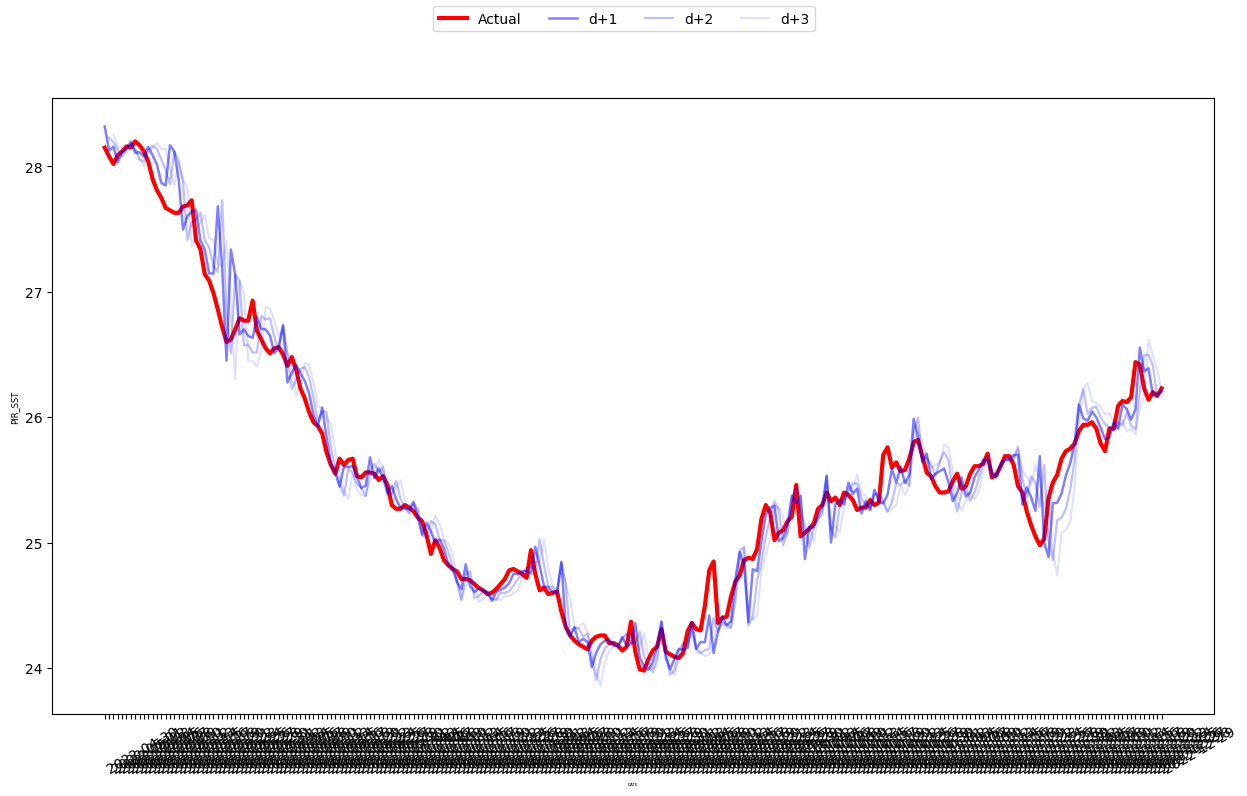

In [41]:
#Visualização da acurácia em gráfico

if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df_sst.plot(x='DATE', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df_sst = eval_df_sst[(eval_df_sst.day=='d+1')][['DATE', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df_sst['d+'+str(t)] = eval_df_sst[(eval_df_sst.day=='d+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_sst['DATE'], plot_df_sst['actual'], color='red', linewidth=3, label="Actual")


    for t in range(1, HORIZON+1):
        x = plot_df_sst['DATE'][(t-1):]
        y = plot_df_sst['d+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=2*math.pow(.9,t), alpha=math.pow(0.5,t), label='d+'+str(t))


    fig.legend(loc='upper center', ncol=4)


plt.xlabel('DATE', fontsize=3,)
plt.xticks(rotation=30, ha='left')
plt.ylabel('PIR_SST', fontsize=6)
plt.show()

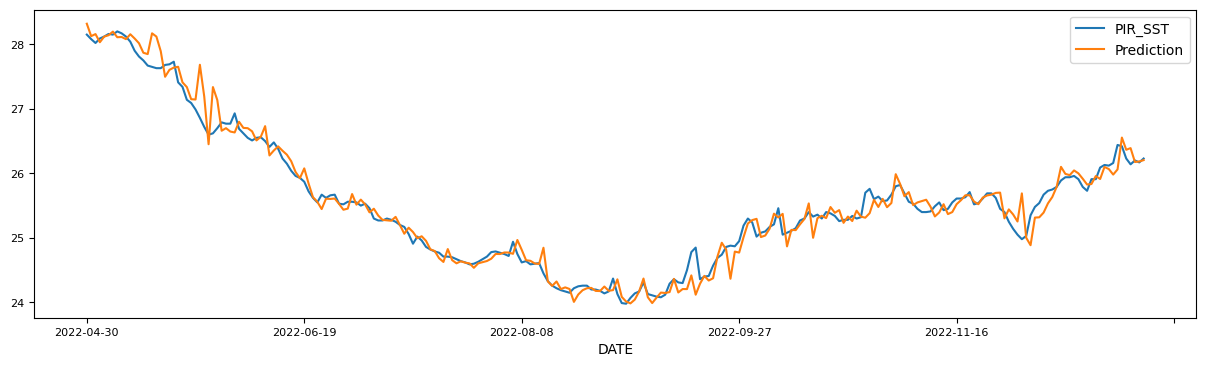

In [42]:
plot_d_sst= eval_df_sst[(eval_df_sst.day=='d+1')][['DATE', 'actual', 'prediction']]
plot_d_sst.plot(x='DATE', y=['actual', 'prediction'], figsize=(15, 4), fontsize=8)
plt.legend(["PIR_SST", "Prediction"]);

<Axes: xlabel='DATE'>

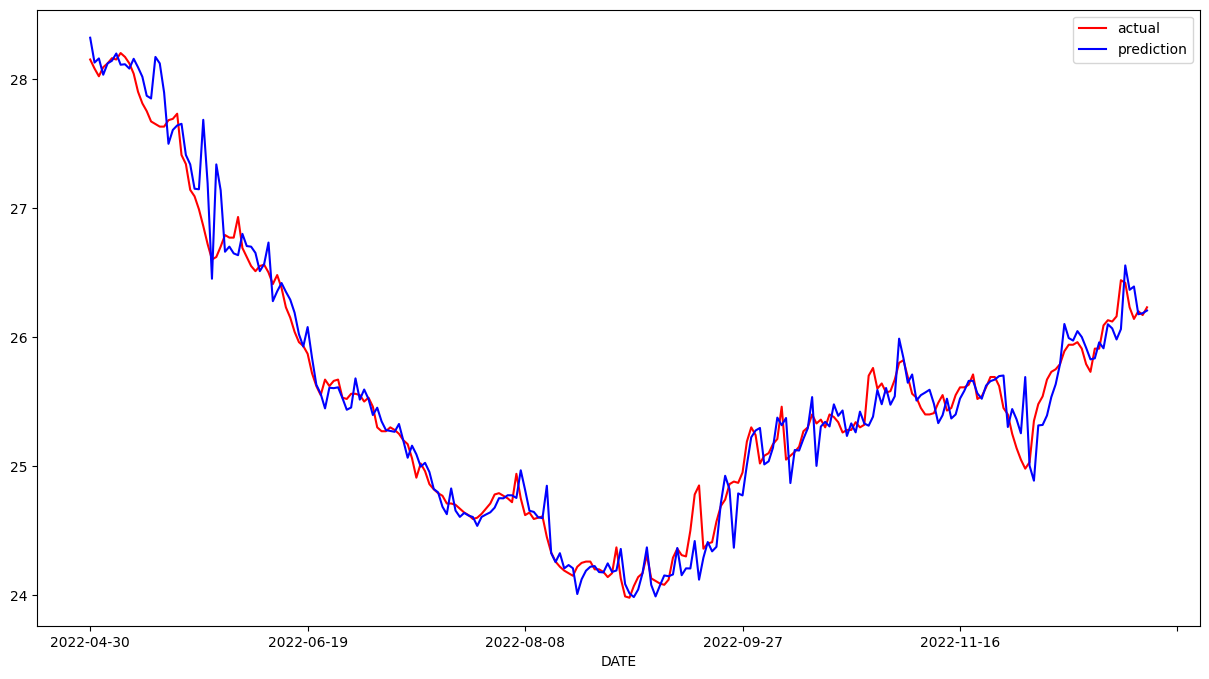

In [43]:
plot_d_sst = eval_df_sst[(eval_df_sst.day=='d+1')][['DATE', 'actual', 'prediction']]
plot_d_sst.plot(x='DATE', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))


<Axes: xlabel='DATE'>

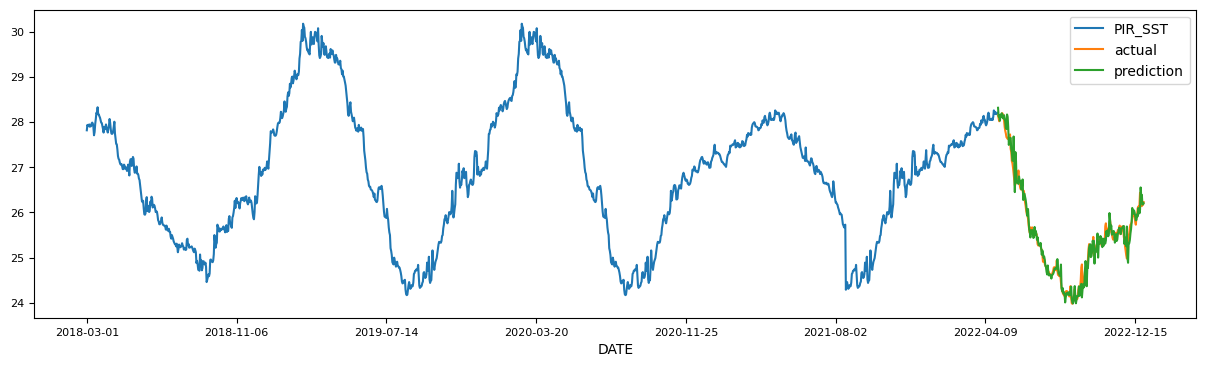

In [44]:
train_c_sst = train_sst.copy()
train_c_sst[['PIR_SST']] = scaler.inverse_transform(train_c_sst[['PIR_SST']])

eval_d_sst = eval_df_sst[(eval_df_sst.day=='d+1')][['DATE', 'actual', 'prediction']]
#eval_c.drop(['day'], axis=1, inplace=True)
#eval_c.drop(['APE'], axis=1, inplace=True)

eval_d_sst.set_index('DATE', inplace=True)


pd.concat([train_c_sst,eval_d_sst],axis=1).plot(figsize=(15, 4), fontsize=8)

#[INM_PREC_TOTAL] Precipitação total

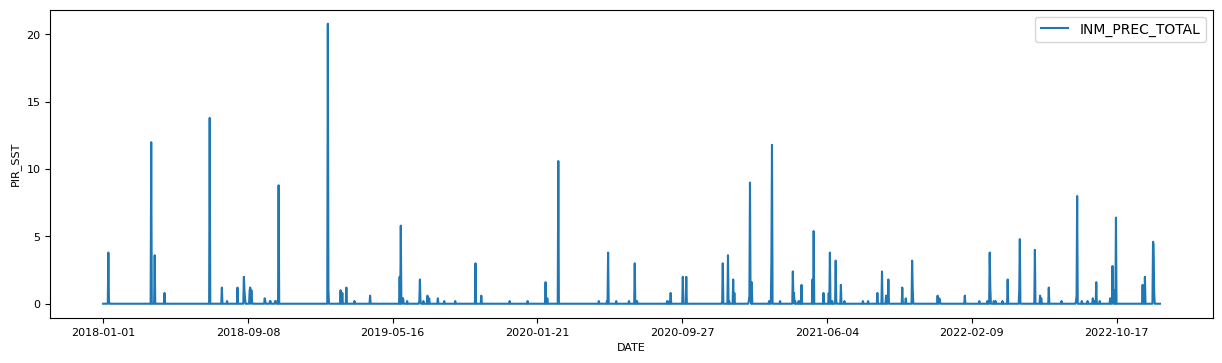

In [45]:
dfOceanAtmo.plot(y='INM_PREC_TOTAL', subplots=True, figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('PIR_SST', fontsize=8)
plt.show()

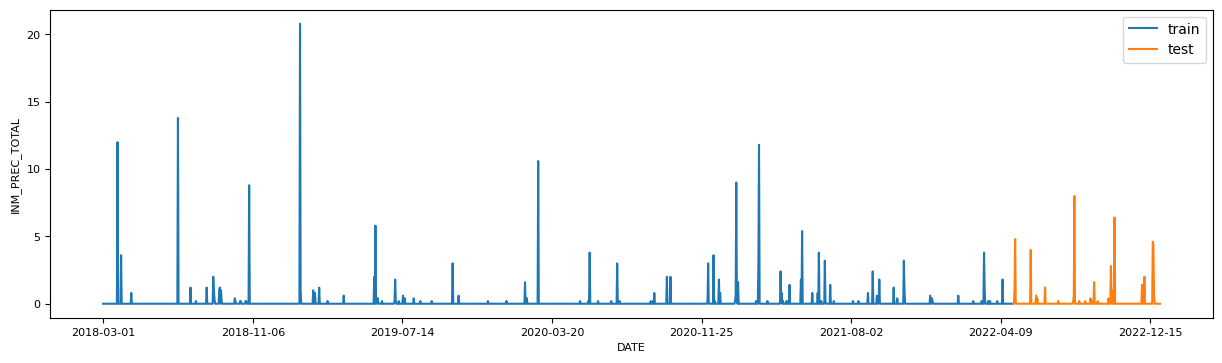

In [46]:

dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['INM_PREC_TOTAL']].rename(columns={'INM_PREC_TOTAL':'train'}) \
    .join(dfOceanAtmo[test_start_dt:][['INM_PREC_TOTAL']].rename(columns={'INM_PREC_TOTAL':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('INM_PREC_TOTAL', fontsize=8)
plt.show()

###Preparação dos dados para treinamento | INM_PREC_TOTAL

In [47]:
train_prt = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['INM_PREC_TOTAL']]
test_prt = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['INM_PREC_TOTAL']]

print('Training data shape: ', train_prt.shape)
print('Test data shape: ', test_prt.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [48]:
from sklearn.preprocessing import RobustScaler
rb = RobustScaler()

In [49]:
#train_prt['INM_PREC_TOTAL'] = rb.fit_transform(train_prt)
#test_prt['INM_PREC_TOTAL'] = rb.transform(test_prt)

In [50]:
#scaler = MinMaxScaler()
#train_prt['INM_PREC_TOTAL'] = scaler.fit_transform(train_prt)
#test_prt['INM_PREC_TOTAL'] = scaler.transform(test_prt)

###Implementação do modelo ARIMA | INM_PREC_TOTAL

In [51]:
stepwise_prt = auto_arima(train_prt, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 7, #7:daily, 12:monthly
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# To print the summary
print(stepwise_prt.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5276.244, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=4841.287, Time=1.91 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=3.13 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5274.244, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=5275.931, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=4652.015, Time=1.69 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=12.08 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=5.72 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=4653.266, Time=2.34 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=4653.708, Time=2.90 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=4653.707, Time=1.98 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=4652.110, Time=1.60 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=4655.698, Time=2.54 sec
 ARIMA(1,0,0)(2,1,0)[7]             : AIC=4650.015, 

In [52]:
#Encontrado os melhores valores para as variaveis p,d,q - seguimos para construção do modelo
order = (1, 0, 0)
seasonal_order = (2, 1, 0, 7)

model_prt = SARIMAX(endog=train_prt, order=order, seasonal_order=seasonal_order)
results_prt = model_prt.fit()

print(results_prt.summary())


                                     SARIMAX Results                                     
Dep. Variable:                    INM_PREC_TOTAL   No. Observations:                 1521
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood               -2321.008
Date:                           Sun, 15 Oct 2023   AIC                           4650.015
Time:                                   19:37:15   BIC                           4671.305
Sample:                               03-01-2018   HQIC                          4657.943
                                    - 04-29-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0463      0.028      1.644      0.100      -0.009       0.102
ar.S.L7       -0.6721      0.006   -116.267

In [53]:
#Criando um test data point para cada horizonte de previsão:

test_shifted_prt = test_prt.copy()

for t in range(1, HORIZON):
    test_shifted_prt['INM_PREC_TOTAL+'+str(t)] = test_shifted_prt['INM_PREC_TOTAL'].shift(-t)

test_shifted_prt = test_shifted_prt.dropna(how='any')

In [54]:
#Fazendo previsões nos dados de teste usando a abordagem de janela deslizante

%%time
training_window = 30 # dedicate 30 days for training

train_ts_prt = train_prt['INM_PREC_TOTAL']
test_ts_prt = test_shifted_prt

history_prt = [x for x in train_ts_prt]
history_prt = history_prt[(-training_window):]

predictions_prt = list()

for t in range(test_ts_prt.shape[0]):
    model_prt = SARIMAX(endog=history_prt, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    model_fit_prt = model_prt.fit()
    yhat_prt = model_fit_prt.forecast(steps = HORIZON)
    predictions_prt.append(yhat_prt)
    obs_prt = list(test_ts_prt.iloc[t])
    # move the training window
    history_prt.append(obs_prt[0])
    history_prt.pop(0)
    #print(test_ts_prt.index[t])
    #print(t+1, ': predicted =', yhat_prt, 'expected =', obs_prt)

CPU times: user 52.8 s, sys: 5.14 s, total: 58 s
Wall time: 54.3 s


In [55]:
#Comparação entre dados atuais e previstos

eval_df_prt = pd.DataFrame(predictions_prt, columns=['d+'+str(t) for t in range(1, HORIZON+1)])
eval_df_prt['DATE'] = test_prt.index[0:len(test_prt.index)-HORIZON+1]
eval_df_prt = pd.melt(eval_df_prt, id_vars='DATE', value_name='prediction', var_name='day')
eval_df_prt['actual'] = np.array(np.transpose(test_ts_prt)).ravel()
eval_df_prt[['prediction', 'actual']] = scaler.inverse_transform(eval_df_prt[['prediction', 'actual']])
eval_df_prt.head()

,DATE,day,prediction,actual
0,2022-04-30,d+1,24.17,24.17
1,2022-05-01,d+1,24.17,24.17
2,2022-05-02,d+1,24.17,30.18
3,2022-05-03,d+1,24.17,53.02
4,2022-05-04,d+1,49.37,24.17


In [56]:
#Tunning to transform negative values to positive
#eval_df_prt['prediction'] = eval_df_prt['prediction'].abs()
#eval_df_prt['actual'] = eval_df_prt['actual'].abs()

###Validação da acurácia do modelo | INM_PREC_TOTAL


In [57]:
#https://stephenallwright.com/calculate-mape-with-0-values/
def smape(actuals, predictions):
    return 1/len(actuals) * np.sum(2 * np.abs(predictions - actuals) / (np.abs(actuals) + np.abs(predictions)))

In [58]:
print('One step forecast SMAPE: ', (smape(eval_df_prt[eval_df_prt['day'] == 'd+1']['actual'], eval_df_prt[eval_df_prt['day'] == 'd+1']['prediction'].abs())), '%')

One step forecast SMAPE:  0.08810709991580026 %


In [59]:
#Equação:
if(HORIZON > 1):
    eval_df_prt['APE'] = (eval_df_prt['prediction'] - eval_df_prt['actual']) / eval_df_prt['actual']
    print(eval_df_prt.groupby('day')['APE'].mean())

day
d+1   0.05
d+2   0.05
d+3   0.05
Name: APE, dtype: float64


In [60]:
print('One step forecast MAPE: ', (mape(eval_df_prt[eval_df_prt['day'] == 'd+1']['prediction'], eval_df_prt[eval_df_prt['day'] == 'd+1']['actual'].abs()))*100, '%')
print('Multi-step forecast MAPE: ', mape(eval_df_prt['prediction'].abs(), eval_df_prt['actual'].abs())*100, '%')

One step forecast MAPE:  10.47729763187977 %
Multi-step forecast MAPE:  10.144818986060402 %


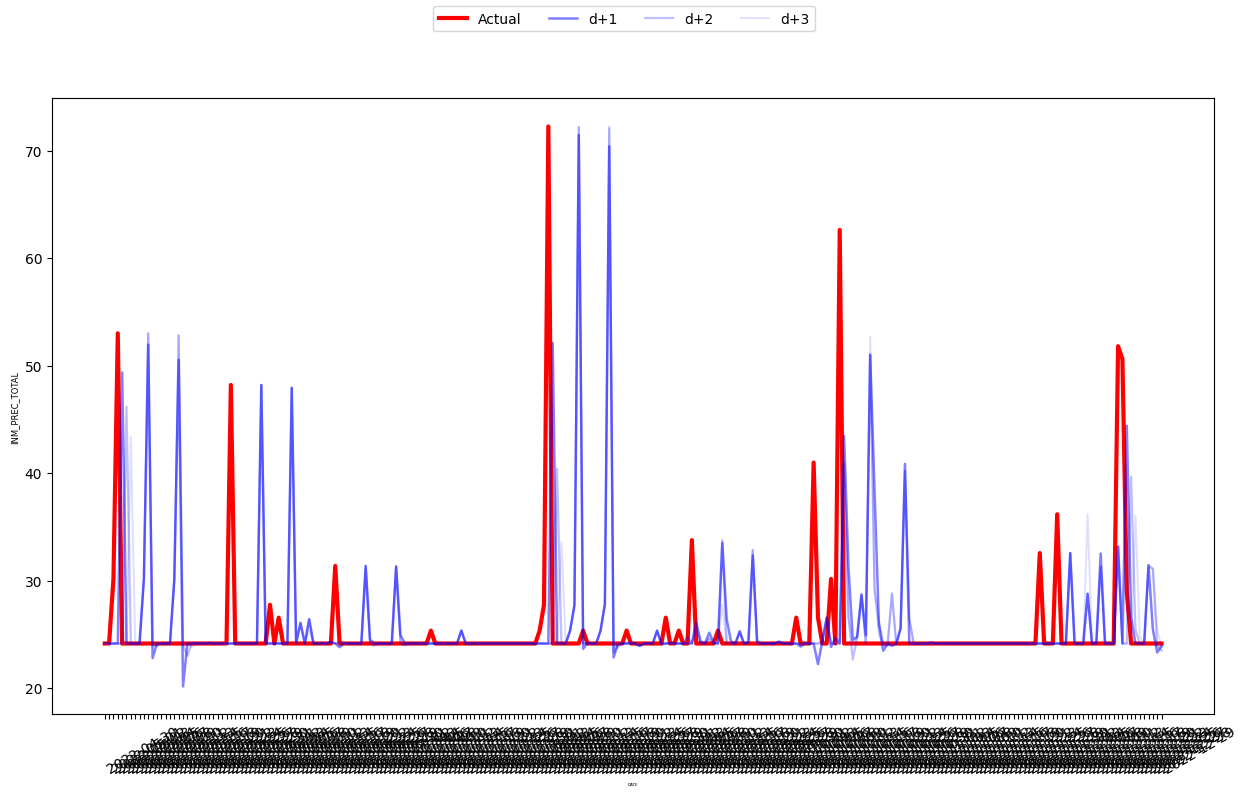

In [61]:
#Visualização da acurácia em gráfico

if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df_prt.plot(x='DATE', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df_prt = eval_df_prt[(eval_df_prt.day=='d+1')][['DATE', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df_prt['d+'+str(t)] = eval_df_prt[(eval_df_prt.day=='d+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_prt['DATE'], plot_df_prt['actual'], color='red', linewidth=3, label="Actual")


    for t in range(1, HORIZON+1):
        x = plot_df_prt['DATE'][(t-1):]
        y = plot_df_prt['d+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=2*math.pow(.9,t), alpha=math.pow(0.5,t), label='d+'+str(t))


    fig.legend(loc='upper center', ncol=4)


plt.xlabel('DATE', fontsize=3,)
plt.xticks(rotation=30, ha='left')
plt.ylabel('INM_PREC_TOTAL', fontsize=6)
plt.show()

<Axes: xlabel='DATE'>

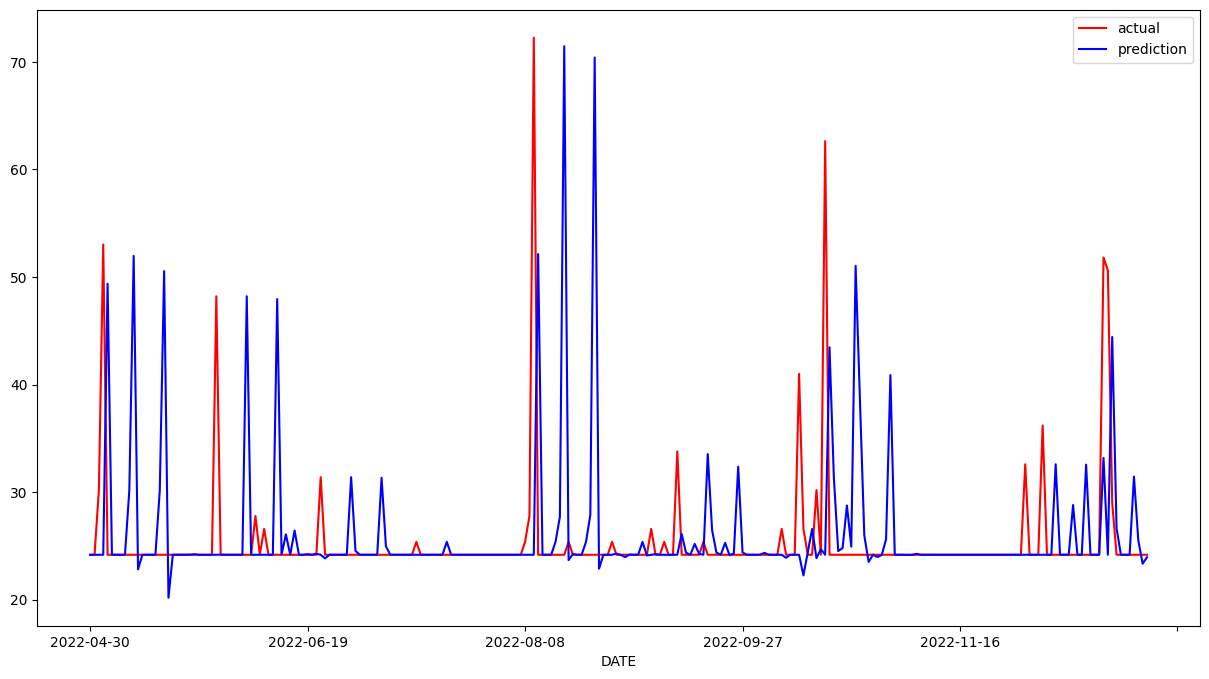

In [62]:
plot_d_prt = eval_df_prt[(eval_df_prt.day=='d+1')][['DATE', 'actual', 'prediction']]
plot_d_prt.plot(x='DATE', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

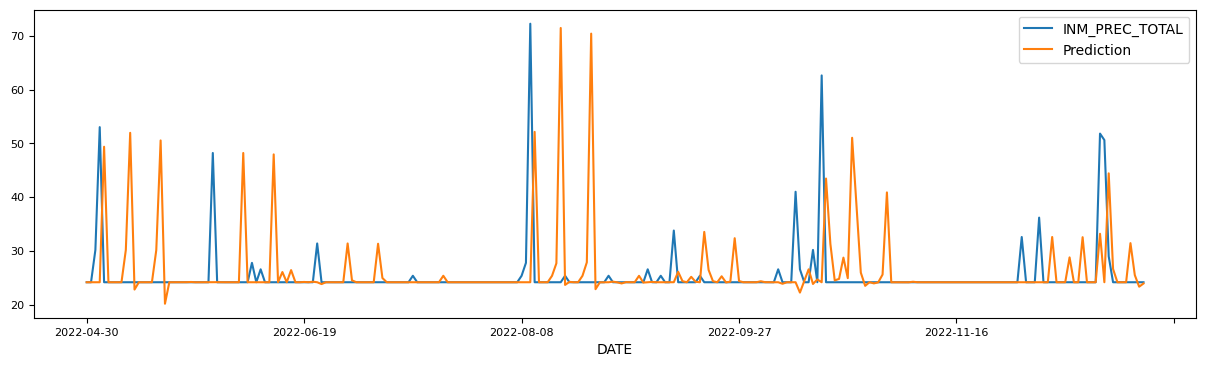

In [63]:
plot_d_1 = eval_df_prt[(eval_df_prt.day=='d+1')][['DATE', 'actual', 'prediction']]
plot_d_1.plot(x='DATE', y=['actual', 'prediction'], figsize=(15, 4), fontsize=8)
plt.legend(["INM_PREC_TOTAL", "Prediction"]);

<Axes: xlabel='DATE'>

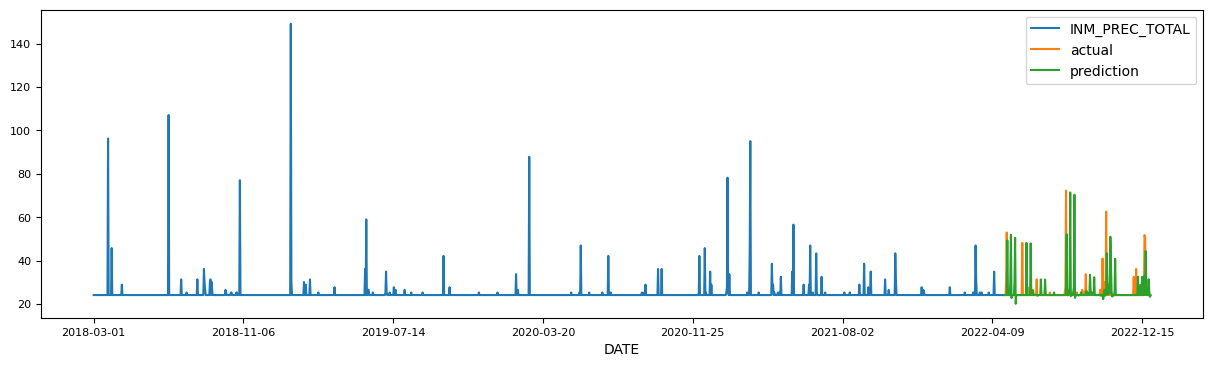

In [64]:
train_c_prt = train_prt.copy()
train_c_prt[['INM_PREC_TOTAL']] = scaler.inverse_transform(train_c_prt[['INM_PREC_TOTAL']])

eval_d_prt = eval_df_prt[(eval_df_prt.day=='d+1')][['DATE', 'actual', 'prediction']]
#eval_c.drop(['day'], axis=1, inplace=True)
#eval_c.drop(['APE'], axis=1, inplace=True)

eval_d_prt.set_index('DATE', inplace=True)


pd.concat([train_c_prt,eval_d_prt],axis=1).plot(figsize=(15, 4), fontsize=8)

#[INM_UMID_AR] Umidade relativa do ar

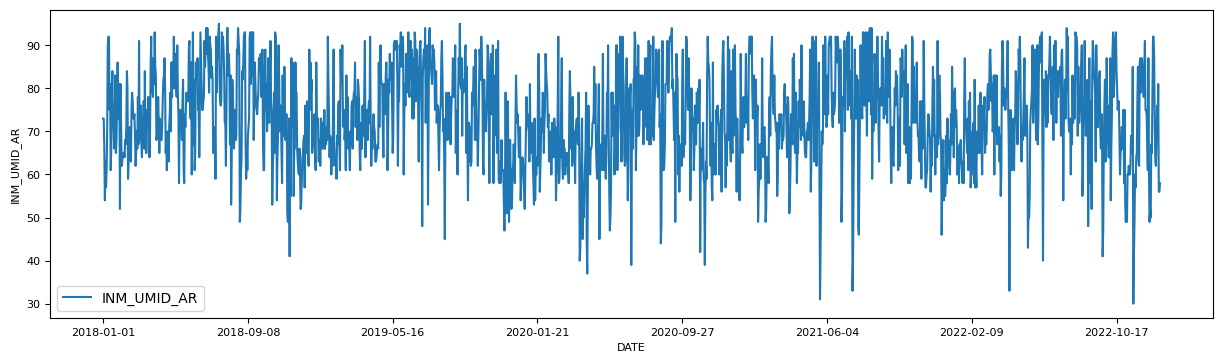

In [65]:
dfOceanAtmo.plot(y='INM_UMID_AR', subplots=True, figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('INM_UMID_AR', fontsize=8)
plt.show()

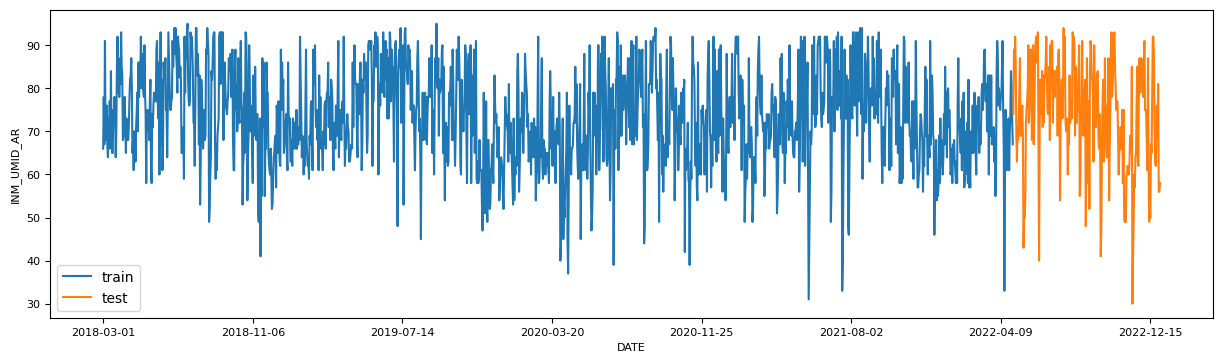

In [66]:
dfOceanAtmo[(dfOceanAtmo.index < test_start_dt) & (dfOceanAtmo.index >= train_start_dt)][['INM_UMID_AR']].rename(columns={'INM_UMID_AR':'train'}) \
    .join(dfOceanAtmo[test_start_dt:][['INM_UMID_AR']].rename(columns={'INM_UMID_AR':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 4), fontsize=8)
plt.xlabel('DATE', fontsize=8)
plt.ylabel('INM_UMID_AR', fontsize=8)
plt.show()

###Preparação dos dados para treinamento | INM_UMID_AR

In [67]:
train_umi = dfOceanAtmo.copy()[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['INM_UMID_AR']]
test_umi = dfOceanAtmo.copy()[dfOceanAtmo.index >= test_start_dt][['INM_UMID_AR']]

print('Training data shape: ', train_umi.shape)
print('Test data shape: ', test_umi.shape)

Training data shape:  (1521, 1)
Test data shape:  (246, 1)


In [68]:
scaler = MinMaxScaler()
train_umi['INM_UMID_AR'] = scaler.fit_transform(train_umi)
train_umi.head(10)

,INM_UMID_AR
DATE,
2018-03-01,0.55
2018-03-02,0.73
2018-03-03,0.56
2018-03-04,0.94
2018-03-05,0.58
2018-03-06,0.61
2018-03-07,0.70
2018-03-08,0.56
2018-03-09,0.52


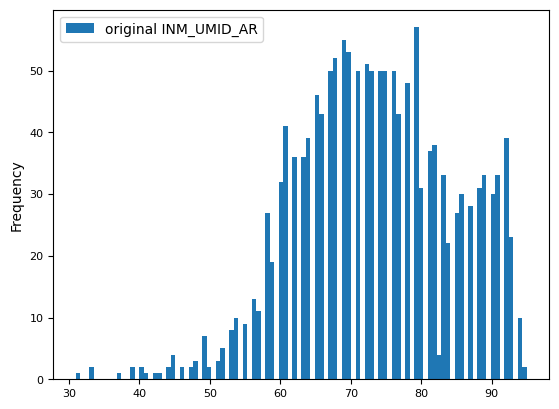

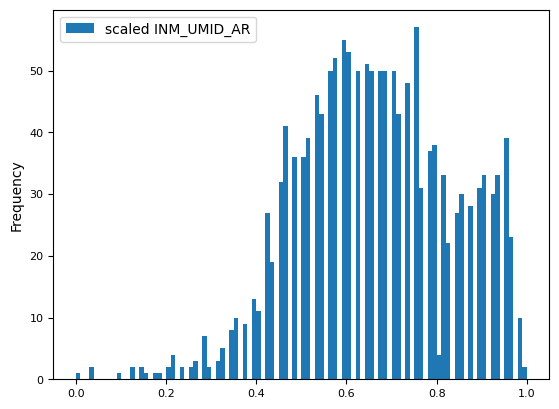

In [69]:
#Dados originais x dados escalados

dfOceanAtmo[(dfOceanAtmo.index >= train_start_dt) & (dfOceanAtmo.index < test_start_dt)][['INM_UMID_AR']].rename(columns={'INM_UMID_AR':'original INM_UMID_AR'}).plot.hist(bins=100, fontsize=8)
train_umi.rename(columns={'INM_UMID_AR':'scaled INM_UMID_AR'}).plot.hist(bins=100, fontsize=8)
plt.show()

In [70]:
#Após os dados escalados calibrados, escalamos os dados de teste

test_umi['INM_UMID_AR'] = scaler.transform(test_umi)
test_umi.head()

,INM_UMID_AR
DATE,
2022-04-30,0.67
2022-05-01,0.91
2022-05-02,0.86
2022-05-03,0.95
2022-05-04,0.84


###Implementação do modelo ARIMA | INM_UMID_AR

In [71]:
stepwise_umi = auto_arima(train_umi, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 7,    #7:daily, 12:monthly
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',         # we don't want to know if an order does not work
                          suppress_warnings = True,       # we don't want convergence warnings
                          stepwise = True)                # set to stepwise

# To print the summary
print(stepwise_umi.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-150.335, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-792.214, Time=2.14 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=6.24 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-152.335, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-348.471, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=-994.225, Time=3.28 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=13.09 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=8.24 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=-750.276, Time=2.89 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=-994.248, Time=7.00 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=-792.432, Time=3.61 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=15.76 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=10.04 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=-992.832, Time=6.3

In [72]:
#Encontrado os melhores valores para as variaveis p,d,q - seguimos para construção do modelo
order = (2, 0, 3)
seasonal_order = (2, 1, 0, 7)

model_umi = SARIMAX(endog=train_umi, order=order, seasonal_order=seasonal_order)
results_umi = model_umi.fit()

print(results_umi.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        INM_UMID_AR   No. Observations:                 1521
Model:             SARIMAX(2, 0, 3)x(2, 1, [], 7)   Log Likelihood                 544.091
Date:                            Sun, 15 Oct 2023   AIC                          -1072.183
Time:                                    19:45:38   BIC                          -1029.603
Sample:                                03-01-2018   HQIC                         -1056.328
                                     - 04-29-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4264      0.019    -22.120      0.000      -0.464      -0.389
ar.L2         -0.8095      0.017   

In [73]:
#Criando um test data point para cada horizonte de previsão:

test_shifted_umi = test_umi.copy()

for t in range(1, HORIZON):
    test_shifted_umi['INM_UMID_AR+'+str(t)] = test_shifted_umi['INM_UMID_AR'].shift(-t)

test_shifted_umi = test_shifted_umi.dropna(how='any')
test_shifted_umi.head(5)

,INM_UMID_AR,INM_UMID_AR+1,INM_UMID_AR+2
DATE,,,
2022-04-30,0.67,0.91,0.86
2022-05-01,0.91,0.86,0.95
2022-05-02,0.86,0.95,0.84
2022-05-03,0.95,0.84,0.59
2022-05-04,0.84,0.59,0.50


In [74]:
#Fazendo previsões nos dados de teste usando a abordagem de janela deslizante

%%time
training_window = 30 # dedicate 30 days for training

train_ts_umi = train_umi['INM_UMID_AR']
test_ts_umi = test_shifted_umi

history_umi = [x for x in train_ts_umi]
history_umi = history_umi[(-training_window):]

predictions_umi = list()

for t in range(test_ts_umi.shape[0]):
    model_umi = SARIMAX(endog=history_umi, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    model_fit_umi = model_umi.fit()
    yhat_umi = model_fit_umi.forecast(steps = HORIZON)
    predictions_umi.append(yhat_umi)
    obs_umi = list(test_ts_umi.iloc[t])
    # move the training window
    history_umi.append(obs_umi[0])
    history_umi.pop(0)
    #print(test_ts_umi.index[t])
    #print(t+1, ': predicted =', yhat_umi, 'expected =', obs_umi)

CPU times: user 1min 43s, sys: 500 ms, total: 1min 44s
Wall time: 1min 45s


In [75]:
#Comparação entre dados atuais e previstos

eval_df_umi = pd.DataFrame(predictions_umi, columns=['d+'+str(t) for t in range(1, HORIZON+1)])
eval_df_umi['DATE'] = test_umi.index[0:len(test_umi.index)-HORIZON+1]
eval_df_umi = pd.melt(eval_df_umi, id_vars='DATE', value_name='prediction', var_name='day')
eval_df_umi['actual'] = np.array(np.transpose(test_ts_umi)).ravel()
eval_df_umi[['prediction', 'actual']] = scaler.inverse_transform(eval_df_umi[['prediction', 'actual']])
eval_df_umi.head()

,DATE,day,prediction,actual
0,2022-04-30,d+1,65.11,74.00
1,2022-05-01,d+1,68.91,89.00
2,2022-05-02,d+1,72.45,86.00
3,2022-05-03,d+1,84.53,92.00
4,2022-05-04,d+1,86.65,85.00


###Validação da acurácia do modelo | INM_UMID_AR

In [76]:
if(HORIZON > 1):
    eval_df_umi['APE'] = (eval_df_umi['prediction'] - eval_df_umi['actual']).abs() / eval_df_umi['actual']
    print(eval_df_umi.groupby('day')['APE'].mean())

day
d+1   0.19
d+2   0.19
d+3   0.20
Name: APE, dtype: float64


In [77]:
print('One step forecast MAPE: ', (mape(eval_df_umi[eval_df_umi['day'] == 'd+1']['prediction'], eval_df_umi[eval_df_umi['day'] == 'd+1']['actual']))*100, '%')
print('Multi-step forecast MAPE: ', mape(eval_df_umi['prediction'], eval_df_umi['actual'])*100, '%')

One step forecast MAPE:  18.782165233795446 %
Multi-step forecast MAPE:  19.116276825266894 %


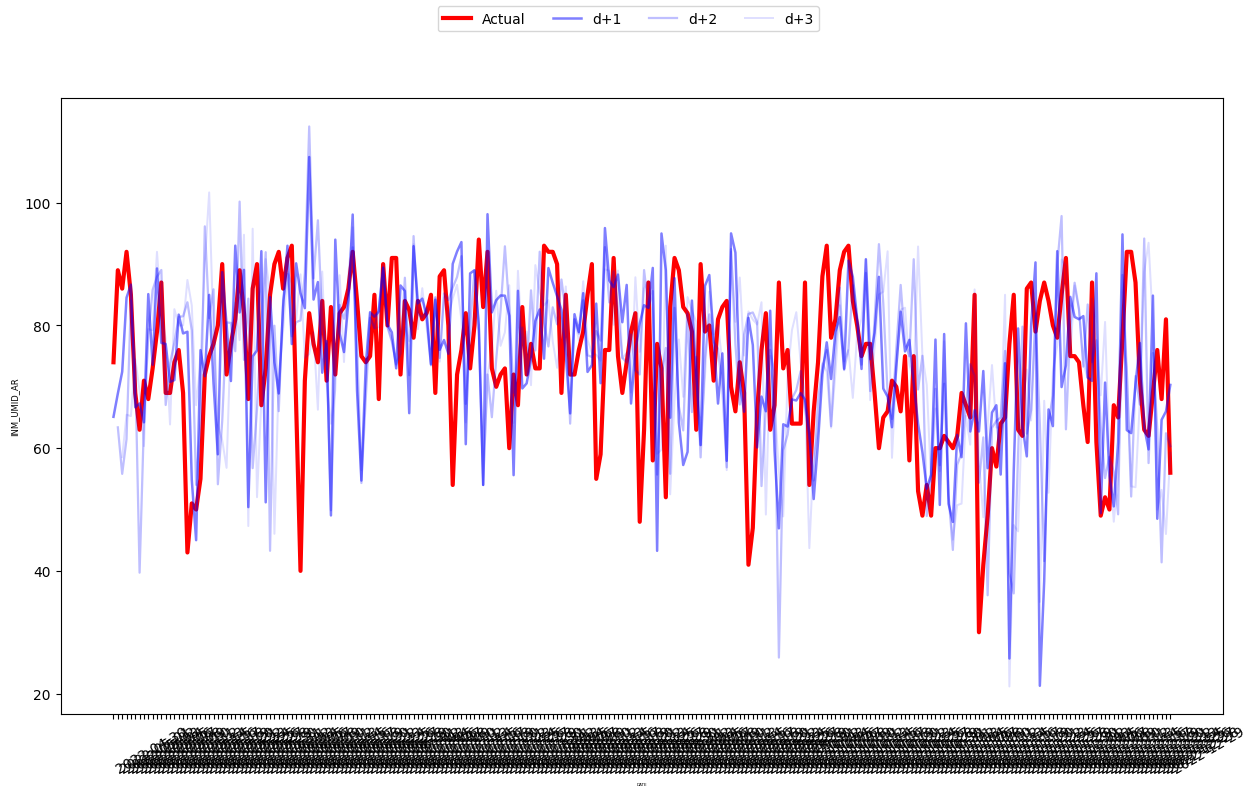

In [78]:
#Visualização da acurácia em gráfico

if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df_umi.plot(x='DATE', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df_umi = eval_df_umi[(eval_df_umi.day=='d+1')][['DATE', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df_umi['d+'+str(t)] = eval_df_umi[(eval_df_umi.day=='d+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_umi['DATE'], plot_df_umi['actual'], color='red', linewidth=3, label="Actual")


    for t in range(1, HORIZON+1):
        x = plot_df_umi['DATE'][(t-1):]
        y = plot_df_umi['d+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=2*math.pow(.9,t), alpha=math.pow(0.5,t), label='d+'+str(t))


    fig.legend(loc='upper center', ncol=4)


plt.xlabel('DATE', fontsize=3,)
plt.xticks(rotation=30, ha='left')
plt.ylabel('INM_UMID_AR', fontsize=6)
plt.show()

<Axes: xlabel='DATE'>

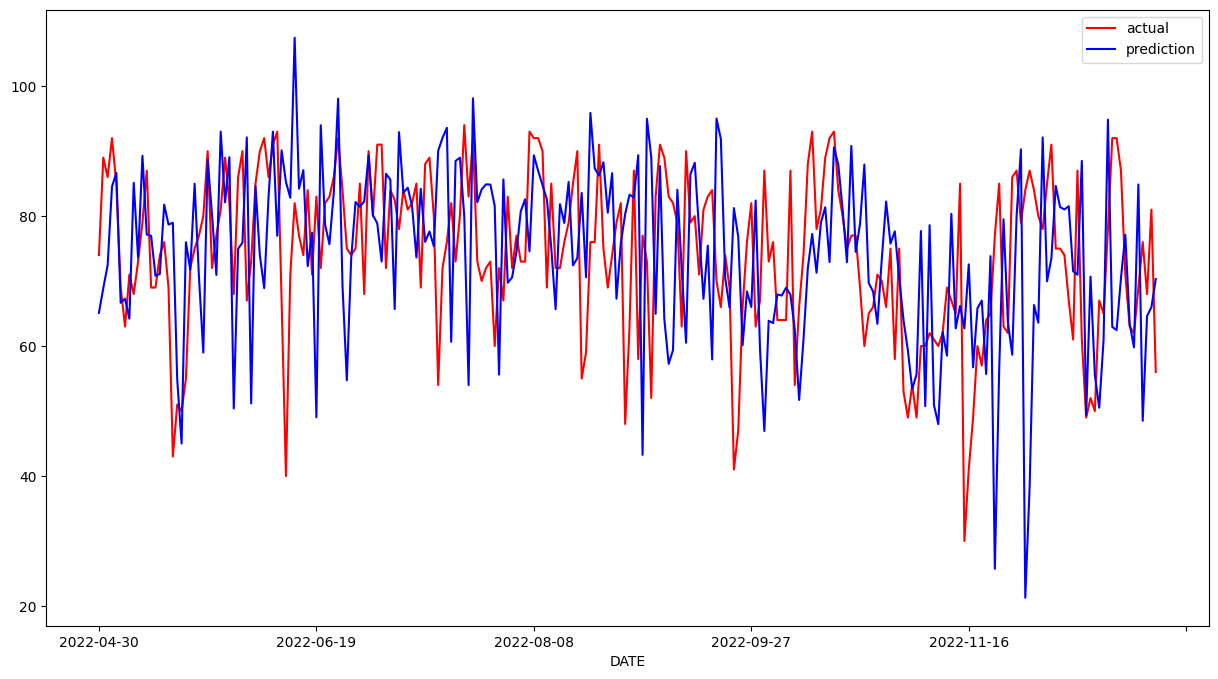

In [79]:
plot_d_umi = eval_df_umi[(eval_df_umi.day=='d+1')][['DATE', 'actual', 'prediction']]
plot_d_umi.plot(x='DATE', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

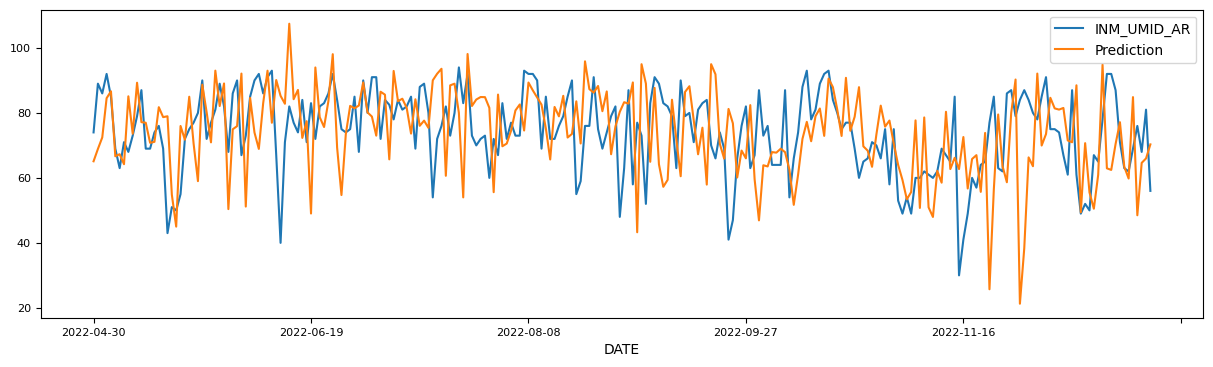

In [80]:
plot_d_umi = eval_df_umi[(eval_df_umi.day=='d+1')][['DATE', 'actual', 'prediction']]
plot_d_umi.plot(x='DATE', y=['actual', 'prediction'], figsize=(15, 4), fontsize=8)
plt.legend(["INM_UMID_AR", "Prediction"]);

<Axes: xlabel='DATE'>

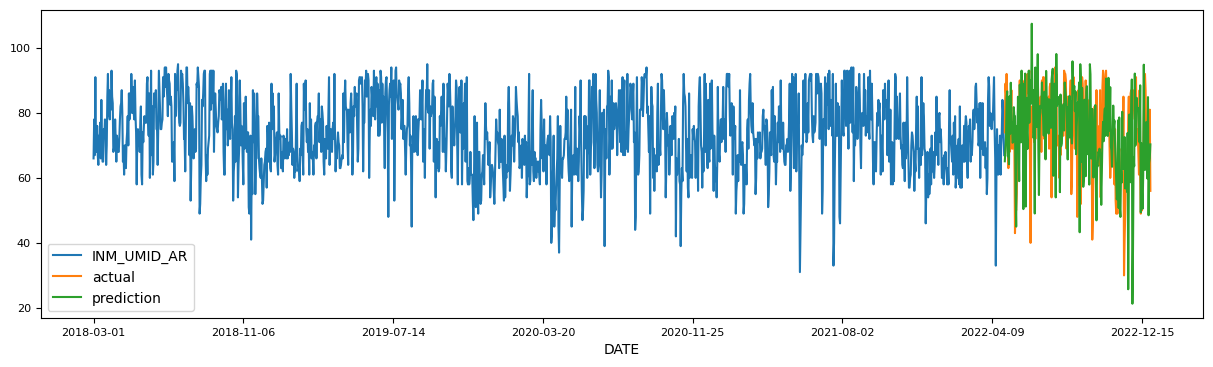

In [81]:
train_c_umi = train_umi.copy()
train_c_umi[['INM_UMID_AR']] = scaler.inverse_transform(train_c_umi[['INM_UMID_AR']])

eval_d_umi = eval_df_umi[(eval_df_umi.day=='d+1')][['DATE', 'actual', 'prediction']]
#eval_c.drop(['day'], axis=1, inplace=True)
#eval_c.drop(['APE'], axis=1, inplace=True)

eval_d_umi.set_index('DATE', inplace=True)


pd.concat([train_c_umi,eval_d_umi],axis=1).plot(figsize=(15, 4), fontsize=8)